[View in Colaboratory](https://colab.research.google.com/github/fromppf/keras/blob/master/oxford_deepNLP_2017_practical_2.ipynb)

### Practical 2: Text Classification
Practical 2: Text Classification
[Chris Dyer, Yannis Assael, Brendan Shillingford]

TED stands for “Technology, Entertainment, and Design”. Each talk in the corpus is labeled with a series of open labels by annotators, including the labels “technology”, “entertainment”, and “design”. Although some talks are about more than one of these, and about half aren’t labeled as being about any of them! In this assignment, you will build a text classification model that predicts whether a talk is about technology, entertainment, or design--or none of these.

This is an instance of what is called “multi-label classification” (MLC), where each instance may have many different labels. However, we will start off by converting it into an instance of multi-class classification, where each document receives a single label from a finite discrete set of possible labels.

#### Setup and installation
To answer the following questions you are allowed to use any machine learning framework of your taste. The practical demonstrators can provide help for:

* PyTorch (example for regression)
* TensorFlow (example for logistic regression)
Other suggested frameworks: CNTK, Torch, Caffe.

#### Multi-class classification
##### Data preparation
You should reserve the first 1585 documents of the TED talks dataset for training, the subsequent 250 for validation, and the final 250 for testing. Each document will be represented as a pairs of (text, label).

###### Text of talks
Using the training data, you should determine what vocabulary you want for your model. A good rule of thumb is to tokenise and lowercase the text (you did this in the intro practical).

At test time, you will encounter words that were not present in the training set (and they will therefore not have an embedding). To deal with this, map these words to a special token. You will also want to ensure that your training set contains tokens.

###### Labels
Each document should be labeled with label from the set: {Too, oEo, ooD, TEo, ToD, oED, TED, ooo}. You are called to generate labels from the <keywords> tag by checking the existence of one of the following tags: {Technology, Entertainment, Design}.

* None of the keywords → ooo
* “Technology” → Too
* “Entertainment” → oEo
* “Design” → ooD
* “Technology” and “Entertainment” → TEo
* “Technology” and “Design” → ToD
* “Entertainment” and “Design” → oED
* “Technology” and “Entertainment” and “Design” → TED

###### Model
A simple multilayer perceptron classifier operates as follows:

x = embedding(text)
h = tanh(Wx + b)
u = Vh + c
p = softmax(u)
if testing:
    prediction = arg maxy’ py’
else: # training, with y as the given gold label
    loss = -log(py) # cross entropy criterion

We will discuss the embedding function that represents the text as a vector (x) is discussed below. W and V are appropriately sized matrices of learned parameters, b and c are learned bias vectors. The other vectors are intermediate values.

###### Text embedding function
The text embedding function converts a sequence of words into a fixed sized vector representation. Effective models for representing documents as vectors is an open area of research, but in general, trying a few different architectures is important since the optimal architecture depends both on the availability of data and the nature of the problem being solved.

* An astoundingly simple but effective embedding model is the “bag-of-means” representation. Let each word wi in the document (where i ranges over the tokens) be represented by an embedding vector xi. The bag of means representation is
#######    x = (1/N) sumi xi.
Word embeddings can be learned as parameters in the model (either starting from random values or starting from a word embedding model, such as word2vec or GloVe), or they you can use fixed values (again, word2vec or Glove).

* A more sophisticated model uses an bidirectional RNN (/LSTM/GRU) to “read” the document (from left to right and from right to left), and then represents the document by pooling the hidden states across time (e.g., by simply taking their arithmetic average or componentwise maximum) and using that as the document vector. You can explore this next week for your practical assignment on RNNs.

#### Questions
You are called to build a single-layer feed-forward neural network in your favourite framework. The network should treat the labels as 8 independent classes. We suggest Adam as optimiser, and training should place in batches for increased stability (e.g.~50).

1. Compare the learning curves of the model starting from random embeddings, starting from GloVe embeddings (http://nlp.stanford.edu/data/glove.6B.zip; 50 dimensions) or fixed to be the GloVe values. Training in batches is more stable (e.g. 50), which model works best on training vs. test? Which model works best on held-out accuracy?
2. What happens if you try alternative non-linearities (logistic sigmoid or ReLU instead of tanh)?
3. What happens if you add dropout to the network?
4. What happens if you vary the size of the hidden layer?
5. How would the code change if you wanted to add a second hidden layer?
6. How does the training algorithm affect the quality of the model?
7. Project the embeddings of the labels onto 2 dimensions and visualise (each row of the projection matrix V corresponds a label embedding). Do you see anything interesting?

##### (Optional, for enthusiastic students)
Try the same prediction task using a true multi-label classification (MLC) set up.

1. One common approach is to make a bunch of binary classification decisions (one for each label).
2. Note, however, that separate binary classification problems don't model correlation structure. It may be the case that, for sake of argument, the label sequence "ooD" never occurs in the data, but we do not know that aprior when designing the model. MLC is an interesting problem in its own right (the name of the game is modeling label decisions jointly, exploiting correlation structure between them), and neural networks offer some really interesting possibilities for modeling MLC problems that have yet to be adequately explored in the literature. You may want to try adding a CRF at the output, for example.

##### Handin
On paper, show a practical demonstrator your response to these to get signed off.

#### Step 0: Dependencies

In [51]:
#!pip install gensim
#!pip install lxml
#!pip install bokeh

    100% |████████████████████████████████| 13.6MB 94kB/s 
  Running setup.py bdist_wheel for bokeh ... - \ | / - \ | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/0a/56/87/e8aaa58b05288bb4004cb11db4d502134552c996c0d84c0704
Successfully built bokeh


In [0]:
import numpy as np
import os
from random import shuffle
import re
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import collections
import time

#%matplotlib inline

In [0]:
import urllib.request
import zipfile
import lxml.etree

#### Step 1: Load data
output:
input_texts: list of 2085 talk transcriptions (entire text, not tokenized, mixed case, punctuation etc.)
labels: corresponding list of 2085 strings containing several keywords each

In [0]:
# Download the dataset if it's not already there
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [0]:
# extract both the texts and the labels from the xml file
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
texts = doc.xpath('//content/text()')
labels = doc.xpath('//head/keywords/text()')
del doc
#print(input_texts[0])
#print(labels[0])

In [0]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('glove.6B.zip'):
    urllib.request.urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")


In [32]:
#!python -m zipfile -e glove.6B.zip z/
#!python -m gensim.scripts.glove2word2vec --input z/glove.6B.50d.txt --output glove.6B.50d.w2vformat.txt

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'gensim.scripts.glove2word2vec' found in sys.modules after import of package 'gensim.scripts', but prior to execution of 'gensim.scripts.glove2word2vec'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2018-04-12 14:59:25,728 - glove2word2vec - INFO - running /usr/local/lib/python3.6/dist-packages/gensim/scripts/glove2word2vec.py --input z/glove.6B.50d.txt --output glove.6B.50d.w2vformat.txt
2018-04-12 14:59:26,733 - glove2word2vec - INFO - converting 400000 vectors from z/glove.6B.50d.txt to glove.6B.50d.w2vformat.txt
2018-04-12 14:59:27,632 - glove2word2vec - INFO - Converted model with 400000 vectors and 50 dimensions


#### Step2: Preprocessing inputs and labels and building embeddings¶
output:
*  inputs_train: list of 1585 tuples of (token_list, label_integer) for training
*  inputs_test: list of 250 tuples of (token_list, label_integer) for testing
*  inputs_cv: list of 250 tuples of (token_list, label_integer) for cv

In [33]:
# preprocess the texts: lowercase, remove text in parentheses, remove punctuation, tokenize into words (split on whitespace)
#removing text in parentheses
input_texts = [re.sub(r'\([^)]*\)', '', input_text) for input_text in texts]
#lowercase
input_texts = [input_text.lower() for input_text in input_texts]
#remove punctuation
input_texts = [re.sub(r'[^a-z0-9]+', ' ', input_text) for input_text in input_texts]
#tokenize into words
input_texts = [input_text.split() for input_text in input_texts]
len(input_texts)
#input_texts[0][:50]

2085

[   0.   671.5 1343.  2014.5 2686.  3357.5 4029.  4700.5 5372.  6043.5
 6715. ]


<Container object of 10 artists>

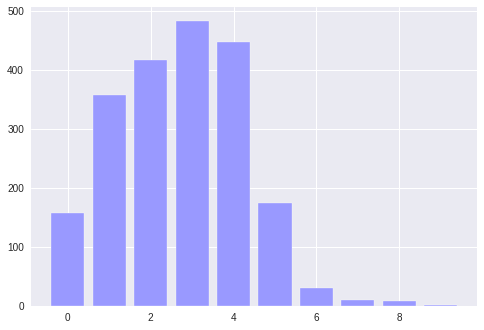

In [34]:
#histogram over input lengths
Y_plot, X_plot = np.histogram([len(text) for text in input_texts], bins=10)
print(X_plot)
X_plot = np.arange(10)
plt.bar(X_plot, +Y_plot, facecolor='#9999ff', edgecolor='white')

In [35]:
#get list of all words, and feed them into a Counter
all_words = [word for input_text in input_texts for word in input_text]
print("There are {} tokens in the dataset.".format(len(all_words)))
all_words_counter = collections.Counter(all_words)

#remove some noise, take away the 100 most common and all words that only appear once
most_common_50 = [word for word, count in all_words_counter.most_common(100)]
only_once = [word for word, count in all_words_counter.most_common() if count == 1]
print("There are {} tokens that appear only once.".format(len(only_once)))

to_remove = set(only_once + most_common_50)
print("There are {} unique tokens to remove.".format(len(to_remove)))

start = time.time()
input_texts = [[word for word in input_text if word not in to_remove] for input_text in input_texts]
print("It took {} seconds to remove all unnecessary items.".format(time.time()-start))

new_all_words = [word for input_text in input_texts for word in input_text]
print("There are now only {} tokens in the dataset.".format(len(new_all_words)))

#input_texts[0]

There are 4474850 tokens in the dataset.
There are 18438 tokens that appear only once.
There are 18538 unique tokens to remove.
It took 0.5699796676635742 seconds to remove all unnecessary items.
There are now only 1926086 tokens in the dataset.


In [36]:
#remove all inputs that have less than 500 tokens in them
inputs = zip(input_texts, labels)
inputs = [text_and_labels for text_and_labels in inputs if len(text_and_labels[0]) > 300]
print("There are now only {} inputs left.".format(len(inputs)))
input_texts, labels = zip(*inputs)
input_texts, labels = list(input_texts), list(labels)

There are now only 1924 inputs left.


In [0]:
#padding every text to the max text length for later batching
#l_max = max([len(text) for text in input_texts])
#for text in input_texts:
#    text += ['<zero_pad>'] * (l_max - len(text))

#truncating every text to only the first 500 tokens
l_max = 1000
input_texts = [text[:l_max] for text in input_texts]
input_texts = [(['<zero_pad>'] * (l_max - len(text)) + text) for text in input_texts]

#print(input_texts[0][-10:-1])
#print(np.mean([len(text) for text in input_texts]) == l_max)

In [38]:
# preprocess the labels: search for occurences of the keywords "technology", "entertainment" or "design" and build labels
label_lookup = ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']
for i in range(len(labels)):
    ted_labels = ['o', 'o', 'o']
    keyword_list = labels[i].split(', ')
    if 'technology' in keyword_list:
        ted_labels[0] = 'T'
    if 'entertainment' in keyword_list:
        ted_labels[1] = 'E'
    if 'design' in keyword_list:
        ted_labels[2] = 'D'
    labels[i] = ''.join(ted_labels)
    labels[i] = label_lookup.index(labels[i])
len(labels)
labels[:20]

[0, 0, 0, 3, 5, 0, 0, 0, 0, 5, 0, 3, 2, 5, 0, 0, 3, 0, 5, 0]

In [39]:
# creating the unique vocabulary lookup
vocab_list = list(set([word for input_text in input_texts for word in input_text]))
word_to_index = {}
index_to_word = {}
for i, word in enumerate(vocab_list):
    word_to_index[word] = i
    index_to_word[i] = word
input_indices_list = []
for input_text in input_texts:
    input_indices_list.append([word_to_index[word] for word in input_text])
len(vocab_list)
#del vocab_list
#del input_texts

35562

In [0]:
#load glove word vectors
glove = KeyedVectors.load_word2vec_format('glove.6B.50d.w2vformat.txt', binary=False)

In [41]:
#creating embeddings, checking for each word in the input texts whether it is part of 
#the glove corpus, if yes intialize that row in the embeddings with the glove value, if
#not initialize it uniformly between [-.1, .1]
voc_len = len(word_to_index)
print("vocabulary size: {} words".format(voc_len))
counter = 0
not_found_list = []
embeddings = np.random.uniform(-.1, .1, size=(voc_len, 50))
for word, index in word_to_index.items():
    if word in glove.vocab:
        counter += 1
        embeddings[index] = glove[word]
    elif word == '<zero_pad>':
        embeddings[index] = np.zeros(50)
    else:
        not_found_list.append(word)
print("found {} word vectors, {} of our vocabulary".format(counter, float(counter)/voc_len))
print("missing words e.g. {}".format(not_found_list[0:50]))

vocabulary size: 35562 words
found 34558 word vectors, 0.9717676171193971 of our vocabulary
missing words e.g. ['roadborne', 'unpicking', 'wasichu', 'eigenmodes', 'shhhhhhh', 'ebox', 'mazing', 'scvngr', 'cloudspotting', 'happinesses', 'barricelli', 'multicentric', 'shukran', 'whipcar', 'redditors', 'rewoven', 'lispenard', 'aquecer', 'rughal', 'wavebands', 'mansukh', 'shinerama', 'chiribiquete', 'hanifaru', 'biofluorescence', 'hackerspaces', 'flowerless', 'sekhri', 'whitopian', 'brakarz', 'electromechanics', 'pappists', 'matere', 'speras', 'femto', 'tedistan', 'cacilda', 'littlebits', 'tedmed', 'searchability', 'madantusi', 'sintia', 'disenthrall', 'decompiculture', 'temporariness', 'dimensionalize', 'pohnay', 'hyperscore', 'hyperconnected', 'enthrallment']


In [42]:
# combining the tokens and labels for each input, then shuffle them and split into train/test/cv
#inputs_combined = list(zip(input_indices_list, labels))
#shuffle(inputs_combined)
#inputs_train = inputs_combined[:1450]
#inputs_test = inputs_combined[1450:1550]
#inputs_cv = inputs_combined[1550:]
#print((len(inputs_train), len(inputs_test), len(inputs_cv)))
#print(inputs_train[0])
#print([index_to_word[i] for i in inputs_train[0][0]])
#print([input_pair[1] for input_pair in inputs_train])

#keep the class label distribution intact
inputs_combined = list(zip(input_indices_list, labels))
inputs_train, inputs_test, inputs_cv = [], [], []
for n in range(len(label_lookup)):
    inputs_of_curr_class = [inpu for inpu in inputs_combined if inpu[1] == n]
    l = len(inputs_of_curr_class)
    split1 = round(0.8*l)
    split2 = round(0.9*l)
    inputs_train.extend(inputs_of_curr_class[:split1])
    inputs_cv.extend(inputs_of_curr_class[split1:split2])
    inputs_test.extend(inputs_of_curr_class[split2:])

shuffle(inputs_train)
shuffle(inputs_cv)
shuffle(inputs_test)
print((len(inputs_train), len(inputs_test), len(inputs_cv)))

(1540, 192, 192)


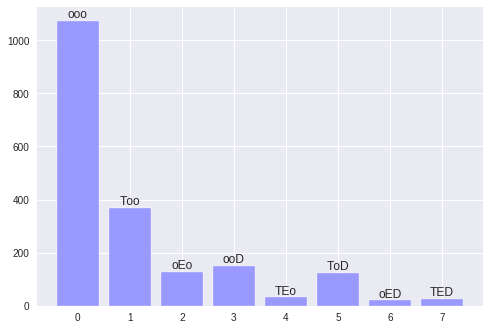

In [43]:
#plotting a histogram over the label distribution in the entire dataset
#as you can see 'ooo' is basically ~50% of the dataset, so an accuracy score
#of 50% could be reached by simply learning to predict 'ooo' all the time (not good)
Y_plot = np.histogram(labels, bins=8)[0]
X_plot = np.arange(8)
plt.bar(X_plot, +Y_plot, facecolor='#9999ff', edgecolor='white')
for x,y in zip(X_plot,Y_plot):
    plt.text(x, y+0.05, label_lookup[x], ha='center', va= 'bottom')

#### Step 3: Building the tensorflow model

In [0]:
# building the tensorflow logistic regression model
import tensorflow as tf

In [0]:
class TextClassifier(object):
    def __init__(self, lr, activation, train_algo, embeddings, train_embeddings, voc_len, embed_size, batch_size, hidden_units, classes):
        #placeholders
        #(batch_size left)
        self.input_ph = tf.placeholder(tf.int32, shape=(None, None), name='input')
        self.labels_ph = tf.placeholder(tf.int32, shape=(None, classes), name='labels')
        self.dropout_ph = tf.placeholder(tf.float32, shape=(), name='dropout')  
        
        #embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            #depending on whether a pre-trained embedding is provided and whether or not
            #the embedding should be trainable
            if embeddings is not None and train_embeddings is True:
                self.L = tf.Variable(embeddings, name="L")
            elif embeddings is not None and train_embeddings is False:
                self.L = tf.constant(embeddings, name="L")
            else:
                self.L = tf.Variable(tf.random_uniform([voc_len, embed_size], -1.0, 1.0), name="L")
            input_vectors = tf.nn.embedding_lookup(self.L, self.input_ph)
            X = tf.squeeze(tf.reduce_mean(input_vectors, axis=1, keep_dims=True), axis=1)
        
        #network model
        with tf.name_scope("network"):
            W1 = tf.Variable(tf.random_normal((embed_size, hidden_units), stddev=0.1), name="W1")
            b1 = tf.Variable(tf.zeros(hidden_units), name='b1')

            self.W2 = tf.Variable(tf.random_normal((hidden_units, classes), stddev=0.1), name="W2")
            b2 = tf.Variable(tf.zeros(classes), name='b2')
            
            if activation == 'relu':
                hidden = tf.nn.relu(tf.matmul(tf.cast(X, tf.float32), W1) + b1)
            elif activation == 'tanh':
                hidden = tf.nn.tanh(tf.matmul(tf.cast(X, tf.float32), W1) + b1)
            else:
                hidden = tf.nn.sigmoid(tf.matmul(tf.cast(X, tf.float32), W1) + b1)
            hidden = tf.nn.dropout(hidden, self.dropout_ph)

            output = tf.matmul(hidden, self.W2) + b2
            output = tf.nn.dropout(output, self.dropout_ph)
            #yhat = tf.nn.softmax(out) #no need to calc whole prob dist if we only want the argmax
            self.predictions = tf.argmax(output, axis=1)
        
        #loss
        with tf.name_scope("loss"):
            self.losses = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=self.labels_ph)
            l2_loss = tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(self.W2) + tf.nn.l2_loss(b2)
            self.loss = tf.reduce_mean(self.losses) + (0.01 * l2_loss)
            
        #acc
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.labels_ph, axis=1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            
        #training operation
        with tf.name_scope("training"):
            if train_algo == 'adam':
                self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)
            elif train_algo == 'adagrad':
                self.train_op = tf.train.AdagradOptimizer(lr).minimize(self.loss)
            else:
                self.train_op = tf.train.GradientDescentOptimizer(lr).minimize(self.loss)

In [0]:
class Trainer(object):
    def __init__(self, nn, train_data, cv_data, test_data, batch_size, train_dropout, epochs):
        self.nn = nn
        self.train_data = train_data
        self.cv_data = cv_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.train_dropout = train_dropout
        self.epochs = epochs
        self.W2, self.collect_preds, self.collect_truth = None, [], []

    def _get_data_batch(self, curr_index, batch_size, data):
        curr_batch = data[curr_index:curr_index+batch_size]
        input_batch_list, labels_batch_list = zip(*curr_batch) #unzip the list of input pair tuples (text, label)
        #print([len(text) for text in input_batch_list])
        curr_input_batch = np.array(input_batch_list, dtype=np.int32)
        one_hot = np.zeros((len(labels_batch_list), classes))            
        one_hot[range(len(labels_batch_list)), labels_batch_list] = 1            
        curr_labels_batch = one_hot
        return curr_input_batch, curr_labels_batch
    
    def _print_status(self, i, epoch_loss, epoch_train_acc, epoch_cv_acc):
        print ("epoch: {}, epoch train loss: {:.3f}, epoch train accuracy: {:.3f}, epoch cv accuracy: {:.3f} ".
               format(i, np.mean(epoch_loss), np.mean(epoch_train_acc), np.mean(epoch_cv_acc)))#, end="\r")
        
    def run_epoch(self, sess, i):
        self.W2 = None
        epoch_loss, epoch_train_acc, epoch_cv_acc = [], [], []
        #run training on the train data
        curr_index = 0
        while curr_index < len(self.train_data):
            curr_input_batch, curr_labels_batch = self._get_data_batch(curr_index, self.batch_size, self.train_data)
            feed_dict={self.nn.dropout_ph:self.train_dropout, 
                       self.nn.input_ph:curr_input_batch, 
                       self.nn.labels_ph:curr_labels_batch}
            self.W2, c_loss, c_losses, c_train_acc, _ = sess.run([self.nn.W2, self.nn.loss, self.nn.losses, self.nn.accuracy, self.nn.train_op], feed_dict=feed_dict)
            #print(c_losses)
            #print(c_loss)
            epoch_loss.append(c_loss)
            epoch_train_acc.append(c_train_acc)
            curr_index += self.batch_size
        
        #run cross evaluation on the cv data
        curr_index = 0
        while curr_index < len(self.cv_data):
            curr_input_batch, curr_labels_batch = self._get_data_batch(curr_index, self.batch_size, self.cv_data)
            feed_dict={self.nn.dropout_ph:1.0, 
                       self.nn.input_ph:curr_input_batch, 
                       self.nn.labels_ph:curr_labels_batch}
            c_cv_acc = sess.run(self.nn.accuracy, feed_dict=feed_dict)
            epoch_cv_acc.append(c_cv_acc)
            curr_index += self.batch_size
        
        self._print_status(i, epoch_loss, epoch_train_acc, epoch_cv_acc)
    
    def train(self):
        print("Starting training for {} epochs.".format(self.epochs))
        with tf.Session() as sess:
            tf.global_variables_initializer().run()
            for i in range(self.epochs):
                self.run_epoch(sess, i)
            print("Done Training.")
            self._test(sess)
        
    def _test(self, sess):
        print("Testing the trained model on the test set.")
        #would be better to choose the best model on cv for this instead of simply the one from the last iteration
        curr_index = 0
        epoch_test_acc = []
        while curr_index < len(self.test_data):
            curr_input_batch, curr_labels_batch = self._get_data_batch(curr_index, self.batch_size, self.test_data)
            feed_dict={self.nn.dropout_ph:1.0, 
                       self.nn.input_ph:curr_input_batch, 
                       self.nn.labels_ph:curr_labels_batch}
            c_test_acc, test_predictions = sess.run([self.nn.accuracy, self.nn.predictions], feed_dict=feed_dict)
            epoch_test_acc.append(c_test_acc)
            self.collect_preds.extend(test_predictions)
            self.collect_truth.extend(np.argmax(curr_labels_batch, axis=1))
            curr_index += self.batch_size
        print("Test set accuracy: {}".format(np.mean(epoch_test_acc)))
        print("Done Testing.")

#### Step 4: Model instantiation, training and testing

In [47]:
#config
embed_size = 50
batch_size = 50
hidden_units = 50
learning_rate = 0.03
voc_len = len(word_to_index)
classes = len(label_lookup)


#instantiate a network
#this can now be tested with all kinds of configurations
#'tanh', 'adam', dropout of 0.5 and a lr of 0.05 seems to work best for me
nn = TextClassifier(
    lr=learning_rate,
    activation='tanh',
    train_algo='adam',
    embeddings=embeddings, #or embeddings=None
    train_embeddings=True,
    voc_len=voc_len,
    embed_size=embed_size,
    batch_size=batch_size,
    hidden_units=hidden_units,
    classes=classes
)

#instantiate a trainer, train the model on the train data and then run the test on the test data
trainer = Trainer(
    nn=nn,
    train_data=inputs_train,
    cv_data=inputs_cv,
    test_data=inputs_test,
    batch_size=batch_size,
    train_dropout=0.5,
    epochs=20
)

trainer.train()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Starting training for 20 epochs.
epoch: 0, epoch train loss: 1.821, epoch train accuracy: 0.470, epoch cv accuracy: 0.534 
epoch: 1, epoch train loss: 1.606, epoch train accuracy: 0.562, epoch cv accuracy: 0.625 
epoch: 2, epoch train loss: 1.513, epoch train accuracy: 0.627, epoch cv accuracy: 0.598 
epoch: 3, epoch train loss: 1.424, epoch train accuracy: 0.675, epoch cv accuracy: 0.656 
epoch: 4, epoch train loss: 1.314, epoch train accuracy: 0.723, epoch cv accuracy: 0.630 
epoch: 5, epoch train loss: 1.315, epoch train accuracy: 0.722, epoch cv accuracy: 0.578 
epoch: 6, epoch train loss: 1.262, epoch train accuracy: 0.739, epoch cv accuracy: 0.656 
epoch: 7, epoch train loss: 1.264, epoch train accuracy: 0.742, epoch cv ac

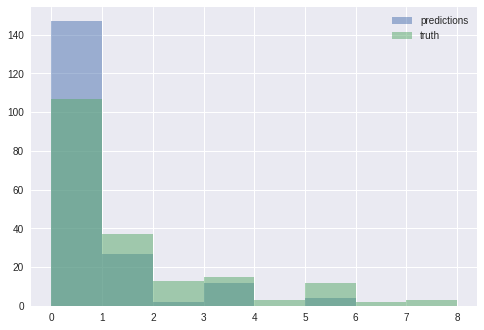

In [48]:
bins = np.arange(9)
plt.hist(np.array(trainer.collect_preds), bins, alpha=0.5, label='predictions')
plt.hist(np.array(trainer.collect_truth), bins, alpha=0.5, label='truth')
plt.legend(loc='upper right')

In [49]:
np.histogram(trainer.collect_truth, bins=8)

(array([107,  37,  13,  15,   3,  12,   2,   3]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]))

#### Step 5: Visualizing the hidden to output weight matrix

In [52]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
plot_W2 = tsne.fit_transform(trainer.W2.T)

In [54]:
label_lookup

['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']

In [56]:
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=plot_W2[:,0],
                                    x2=plot_W2[:,1],
                                    names=label_lookup))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

#### Questions
1. Influence of word embeddings (random init + train) vs. (glove init + train) vs. (glove init + fixed)?
  * embeddings initialized with glove vectors and backpropagating into them was found to be the best variant with ~67% accuracy on the test set
  * worst performance was random init and no backprop into the embeddings, this basically failed to learn anything which makes it clear that proper embeddings are very important for making sense out of text

2. Performance for alternative activations (sigmoid, relu)?
  * for the same parameters (hidden_units, dropout, etc.) the performance was actually tied between all three
  * since the network is quite shallow it doesn't seem to play a big role in terms of vanishing or dying gradients so all three performed equally well (or bad if you look at the performance)

3. What happens when you add dropout?
  * dropout helps in reducing overfitting, the performance gap between the training and cv/test accuracy is now lower (~10%) which indicates a model that would be more able to generalize to new data
4. Hidden layer size variation?
  * does not seem to play a huge role if you start out on reasonable values
  * since the embedding layer has a dimension of 50, the number of hidden units was also chosen to be 50 with the reasoning that it should at least be able to express the same information content as the embeddings
  * much more than 50 didn't show significant differences in performance
5. What to change for adding a second hidden layer?
  * to add a second hidden layer in tensorflow is straightforward by simply defining two new variables (new weight and new bias) and copying the first hidden layer (linear transform -> activation)
  * since 2 layers are still not really "deep" this should work with the same hyperparameters, however when adding even more layers one would have to take care of possible vanishing gradient issues
6. Training algo influence?
  * adam showed the best performance, however standard sgd was basically the same
  * at first I thought it might be worth trying adagrad that might train better by being able to apply higher gradients into the word embeddings but it didn't turn out to be all that different to adam or sgd
7. Graph is at the end of the notebook
  * it seems like the weight embeddings for many of the labels that we failed to learn are lumped close together and also very close to the graph origin
  * this indicates that we haven't really learned much about them and therefore fail to predict them

#### Some insights
* all texts were padded with a special token ('<PAD>') such that each sentence had exactly the length of the longest text in the dataset, this was important to get batching to work
* as a sanity check it is worth thinking about the expected cross-entropy loss for a totally random model...since it is basically -log(yhat_max) for a one-hot ground truth vector, the expected value for 8 classes is -log(1/8) ~ 2.1 (so you should converge towards something significantly lower than that)
* doing some more elaborate preprocessing (removing most frequent and least frequent words from the texts) really helps (i.e. removing noise) also because this removes a lot of the words that we didn't have a pretrained glove vector for
* plotting the label predictions and the ground truth on the test set on top of each other makes it clear that there simply doesn't seem to be enough data for some of the labels

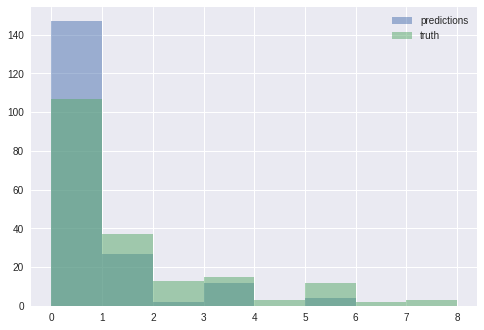

In [57]:
bins = np.arange(9)
plt.hist(np.array(trainer.collect_preds), bins, alpha=0.5, label='predictions')
plt.hist(np.array(trainer.collect_truth), bins, alpha=0.5, label='truth')
plt.legend(loc='upper right')

  *  the overall dataset is dominated by 50% of the label 'ooo' (neither T nor E nor D) with some labels only having around ~20 datapoints overall so there is really not much to learn from for our network and it is not surprising that it is very hard to predict especially those rare labels (see above cell 22)